In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import kagglehub
import os
## loading data and indicating headers
path = kagglehub.dataset_download("anitarostami/enhanced-gait-biomechanics-dataset")
print("Dataset downloaded to:", path)
csv_file = os.path.join(path,"Gait_Biomechanics_Dataset.csv")
df=pd.read_csv(csv_file)
print(df.head())
df['time']=(df['time']*100).round() # because they had 0-1 first with steps of 0.01 now we make it into 1 % steps. they also had a few rounding errors with 14.0000001 which i just made into rounded numbers

## subject: 1 = subject 1, …, 10 = subject 10 (integer)
## condition: 1 = unbraced, 2 = knee brace, 3 = ankle brace (integer)
## replication: 1 = replication 1, …, 10 = replication 10 (integer)
## leg: 1 = left, 2 = right (integer)
## joint: 1 = ankle, 2 = knee, 3 = hip (integer)
## time: 0 = 0% gait cycle, …, 100 = 100% gait cycle (integer)
## angle: Joint angle in degrees (real valued)
## velocity: Normalized velocity of joint angle (real valued)
## acceleration: Normalized acceleration of joint angle (real valued)

d:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded to: C:\Users\c25022289\.cache\kagglehub\datasets\anitarostami\enhanced-gait-biomechanics-dataset\versions\1
   subject  condition  replication  leg  joint  time     angle  velocity  \
0        1          1            1    1      1  0.02  0.306079  0.148743   
1        1          1            1    1      1  0.03  0.304688 -0.139109   
2        1          1            1    1      1  0.04  0.300597 -0.409133   
3        1          1            1    1      1  0.05  0.294758 -0.583894   
4        1          1            1    1      1  0.06  0.288600 -0.615767   

   acceleration  
0    -22.181241  
1    -28.785226  
2    -27.002347  
3    -17.476118  
4     -3.187317  


In [2]:
## goal is to predict based on the angles and the condition what percentage of the gait cycle their in
##loading in the imports
from sklearn.ensemble import RandomForestRegressor

## Gait kinematics are cyclic and largely symmetric between legs.
## As the brace is applied on the right side, only right-leg data are used
## to reduce redundancy while preserving condition-specific effects.

df_right = df[df['leg'] == 2].copy() # only right side
df_right = df_right.pivot_table(
    index=['subject', 'condition','replication', 'time'], 
    columns='joint',                         
    values=['angle', 'velocity', 'acceleration']
)
df_right.columns = [f'{val}_joint{col}' for val, col in df_right.columns]
df_right = df_right.reset_index() ## reseting back to indexes seperate collums
## now we have 10 strides for 10 participants with 3 different conditions
# our predictor value is going to be the stride %
y=df_right['time']
# now the x value is consistant of both continues and non ranged valuesheaders=df_right.head()

X = df_right.drop(['time'], axis=1)# all but time

# data should be splitted over participants so the data never trains on the same participant it tests on
participants = df_right['subject'].unique()
mse = np.zeros(3)
r2  = np.zeros(3)
for i in range(3): # theoretically you should do 120 seeds to see all possible splits but thats to long so just see bit over three seeds
    np.random.seed(i)
    np.random.shuffle(participants)
    random_participants = participants.copy() 
    test_subjects = random_participants[:3]   # first 3 participants
    train_subjects = random_participants[3:]  

    X_train = X[df_right['subject'].isin(train_subjects)]
    y_train = y[df_right['subject'].isin(train_subjects)]

    X_test = X[df_right['subject'].isin(test_subjects)]
    y_test = y[df_right['subject'].isin(test_subjects)]
    
    ## ---- the model -----##
    regr = RandomForestRegressor(max_depth=10,n_estimators=200, random_state=0, oob_score=True) # placed here because I read it does not reset propperly between fits
    ## fitting models
    regr.fit(X_train, y_train)
    predictions = regr.predict(X_test)
 
    # Evaluating the model
    distance = (predictions - y_test + 50) % 100 - 50
    # this will cause the distance lts say 100-1=99+50=149 wrapped in 100%= 49-50= -1 which it should be
    # similarly 1-100=-99+50=-49=51-50=1
    mse[i] = np.mean(distance**2) ## root mean distance
    # R^2 doesnt realy work so we need to do modified ver
print(mse)
# shows some variability but relatively low

[13.36962216 30.47263943 40.23407453]


Mean Squared Error 1: 36.950765467535575
Mean Squared Error 2: 46.45861167909977
Mean Squared Error 3: 37.292846453707625


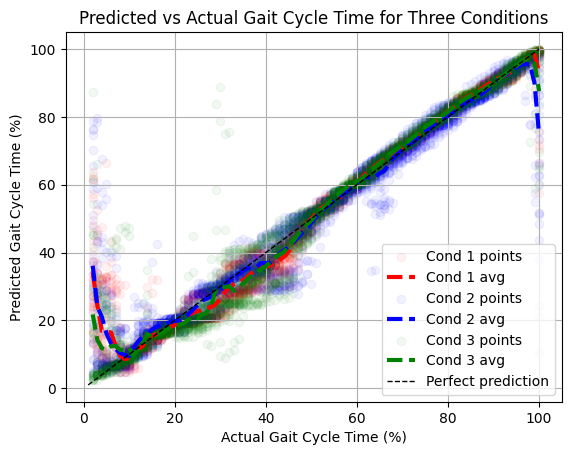

2970
2970
2970


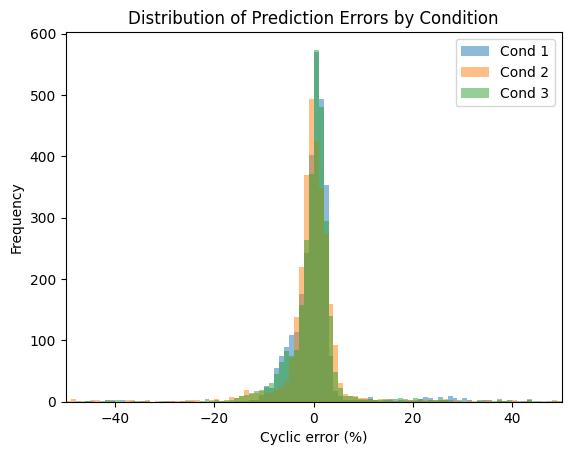

In [3]:
# --- evaluation over the different conditions only for seed 3 as its the last one
color=['red','blue','green']
# Average predicted time per true time bin (rounded)
bins = np.arange(1,101, 1)  # 0-100% gait cycle
for condition in range(1,4):
    mask = X_test['condition'] == condition
    subset_cond = X_test[mask]
    subset_y = y_test[mask]

    predictions = regr.predict(subset_cond)
    distance = (predictions - subset_y + 50) % 100 - 50
    mse_cond = np.mean(distance**2)
    print(f'Mean Squared Error {condition}: {mse_cond}')

    ## display
    plt.scatter(subset_y, predictions, alpha=0.05, color=color[condition-1], label=f"Cond {condition} points")

    
    subset_df = subset_cond.copy()
    subset_df['true_time'] = subset_y.values
    subset_df['pred_time'] = predictions
    subset_df['true_bin'] = subset_df['true_time'].round().astype(int)

    avg_pred_per_bin = [subset_df[subset_df['true_bin']==b]['pred_time'].mean() for b in bins]
    mask_nan = ~np.isnan(avg_pred_per_bin)

    # Line connecting averaged predicted times
    plt.plot(bins[mask_nan], np.array(avg_pred_per_bin)[mask_nan],
             color=color[condition-1], linewidth=3, linestyle='--',
             label=f"Cond {condition} avg")
    

# Perfect prediction line
plt.plot(bins,bins, 'k--', linewidth=1, label="Perfect prediction")

plt.xlabel("Actual Gait Cycle Time (%)")
plt.ylabel("Predicted Gait Cycle Time (%)")
plt.title("Predicted vs Actual Gait Cycle Time for Three Conditions")
plt.legend()
plt.grid(True)
plt.show()
bin_fig = np.linspace(-50, 50, 101)
for condition in range(1,4):
    mask = X_test['condition'] == condition
    subset_cond = X_test[mask]
    subset_y = y_test[mask]

    predictions = regr.predict(subset_cond)
    distance = (predictions - subset_y + 50) % 100 - 50
    print(len(distance))
    plt.hist(distance, bins=bin_fig, alpha=0.5, label=f"Cond {condition}", rwidth=1)
plt.xlim(-50,50)
plt.xlabel("Cyclic error (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors by Condition")
plt.legend()
plt.show()

## --- evaluation ---##
# we notice that the model performs very well but at the start and end of the gaitcycle the larger ranges (likely dependent on starting positions etc) have a lager range
# causing mistakes

In [4]:
# to solve this rounding one could speculate on the dependency of time in a cyclic activity. here the dependency is not actually modeled and seems to only go backwards as it does not see the future.
# however, when we think about cyclic things we usually think about 0-2pi (a circle)
# lets see if we can improve the performance of the model by feeding the time a bit different

## making new time
df_right['cyclic_time']=df_right['time'] * 2 * np.pi / 100
## new y is both the sin and cos of the time which togheter can be reverted into actual time. this will allow for a better cyclic accaptance
y = pd.DataFrame({'sin': np.sin(df_right['cyclic_time']),'cos': np.cos(df_right['cyclic_time']),'time': df_right['time']})
X = df_right.drop(['time', 'cyclic_time'], axis=1)


mse = np.zeros(3)
for i in range(3): # theoretically you should do 120 seeds to see all possible splits but thats to long so just see bit over three seeds
    np.random.seed(i)
    np.random.shuffle(participants)
    random_participants = participants.copy() 
    test_subjects = random_participants[:3]   # first 3 participants
    train_subjects = random_participants[3:]  

    X_train = X[df_right['subject'].isin(train_subjects)]
    y_train = y[df_right['subject'].isin(train_subjects)]

    X_test = X[df_right['subject'].isin(test_subjects)]
    y_test = y[df_right['subject'].isin(test_subjects)]
    
    ## ---- the model -----##
    regr_sin = RandomForestRegressor(max_depth=10, n_estimators=200, random_state=0, oob_score=True)
    regr_cos = RandomForestRegressor(max_depth=10, n_estimators=200, random_state=0, oob_score=True)

    ## fitting models
    regr_sin.fit(X_train, y_train['sin'])
    regr_cos.fit(X_train, y_train['cos'])
    pred_sin = regr_sin.predict(X_test)
    pred_cos = regr_cos.predict(X_test)
 
    # Evaluating the model
    pred_time= np.arctan2(pred_sin, pred_cos) * 100 / (2 * np.pi) % 100
    actual_time=y_test['time']
    ## mse and r2 for cyclic data
    # distance is actual changed distance so 100 only 1 away from 1% 
    # 10.18637/jss.v031.i10 we use there codes without actually importing
    distance = (pred_time - actual_time + 50) % 100 - 50
    # this will cause the distance lts say 100-1=99+50=149 wrapped in 100%= 49-50= -1 which it should be
    # similarly 1-100=-99+50=-49=51-50=1
    mse[i] = np.mean(distance**2) ## root mean distance
    # R^2 doesnt realy work so we need to do modified version which is complicated and i will skip so we base it on mse for now (its easy with packages but whant to limit packages)
print(mse)

[15.31960085 11.67739547  9.38011153]


Mean Squared Error 1: 6.608735601378107
Mean Squared Error 2: 13.739297187681123
Mean Squared Error 3: 7.792301799054223


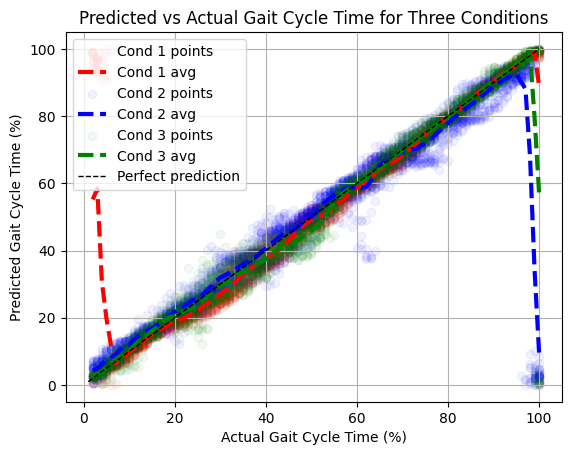

2970
2970
2970


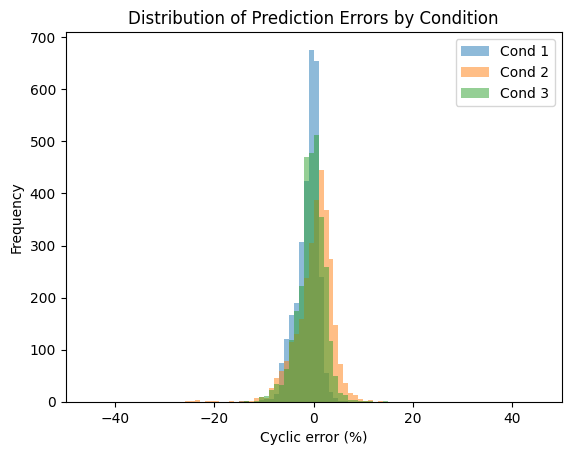

In [5]:
# --- evaluation over the different conditions only for seed 3 as its the last one
color=['red','blue','green']
# Average predicted time per true time bin (rounded)
bins = np.arange(1,101, 1)  # 0-100% gait cycle
for condition in range(1,4):
    mask = X_test['condition'] == condition
    subset_cond = X_test[mask]
    subset_y = y_test[mask]

    pred_sin = regr_sin.predict(subset_cond)
    pred_cos = regr_cos.predict(subset_cond)
    pred_time = (np.arctan2(pred_sin, pred_cos) * 100 / (2 * np.pi)) % 100
    actual_time=subset_y['time']

    distance = (pred_time - actual_time + 50) % 100 - 50
    mse_cond = np.mean(distance**2)
    print(f'Mean Squared Error {condition}: {mse_cond}')

    ## display
    plt.scatter(actual_time, pred_time, alpha=0.05, color=color[condition-1], label=f"Cond {condition} points")

    
    subset_df = subset_cond.copy()
    subset_df['true_time'] = actual_time
    subset_df['pred_time'] = pred_time
    subset_df['true_bin'] = subset_df['true_time'].round().astype(int)

    avg_pred_per_bin = [subset_df[subset_df['true_bin']==b]['pred_time'].mean() for b in bins]
    mask_nan = ~np.isnan(avg_pred_per_bin)

    # Line connecting averaged predicted times
    plt.plot(bins[mask_nan], np.array(avg_pred_per_bin)[mask_nan],
             color=color[condition-1], linewidth=3, linestyle='--',
             label=f"Cond {condition} avg")

# Perfect prediction line
plt.plot(bins,bins, 'k--', linewidth=1, label="Perfect prediction")

plt.xlabel("Actual Gait Cycle Time (%)")
plt.ylabel("Predicted Gait Cycle Time (%)")
plt.title("Predicted vs Actual Gait Cycle Time for Three Conditions")
plt.legend()
plt.grid(True)
plt.show()


for condition in range(1,4):
    mask = X_test['condition'] == condition
    subset_cond = X_test[mask]
    subset_y = y_test[mask]

    pred_sin = regr_sin.predict(subset_cond)
    pred_cos = regr_cos.predict(subset_cond)
    pred_time = (np.arctan2(pred_sin, pred_cos) * 100 / (2 * np.pi)) % 100
    
    actual_time=subset_y['time']

    distance = (pred_time - actual_time + 50) % 100 - 50
    print(len(distance))
    plt.hist(distance, bins=bin_fig, alpha=0.5, label=f"Cond {condition}")
plt.xlim(-50,50)
plt.xlabel("Cyclic error (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors by Condition")
plt.legend()
plt.show()
## --- evaluation ---##
# the end and start still look bit weird but that makes sense as 100 and 0 % are very close to each other. the mean squared error has improved in all three conditions showing a precision of around 3%
# concentration of the error spread looks more around 0